## 初始化

In [1]:
import torch
from model import Model,device
from eeg_dataset import EEG_Dataset

'''从分类结果获得显著图'''
dataset = EEG_Dataset(path='C:/Users/14152/Desktop/eegbin/dataset')
m = Model(8,5).to(device)
m.eval() 

Loaded files: ['co1_1.npz', 'co_1_2.npz', 'vs1_1.npz', 'vs2_1.npz']
Total entries: 5405
co count: 2057
vs count: 3348


Model(
  (gcn1): GCNConv(5, 40)
  (gcn2): GCNConv(40, 40)
  (gcn3): GCNConv(40, 40)
  (gcn4): GCNConv(40, 1)
  (fc_g): Linear(in_features=16, out_features=16, bias=True)
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc_c): Linear(in_features=4096, out_features=16, bias=True)
  (fc1): Linear(in_features=32, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=2, bias=True)
)

## 样本前向计算

In [2]:
(x1,x2),y = dataset[5000]
x1 = x1.unsqueeze(0)
x2 = x2.unsqueeze(0)
x1.requires_grad_(),x2.requires_grad_()

print(x1.shape,x2.shape)
output = m(x1,x2)

prediction = output.argmax().item()
truth = y.argmax().item()


print(f"预测：{output}\n实际：{y}\n{prediction==truth}")

torch.Size([1, 16, 5]) torch.Size([1, 16, 16])
预测：tensor([[0.4479, 0.4696]], device='cuda:0', grad_fn=<SigmoidBackward0>)
实际：tensor([0., 1.], device='cuda:0')
True


## 反向计算梯度

注意，下面的cell只能运行一遍，再次运行会报错，需要重新运行上面的cell
因为torch的tensor只能.backward()一次

In [3]:
m.zero_grad()
output[0, prediction].backward() # 0是batch的维度
saliency_x1 = x1.grad.data.abs().squeeze(0).cpu().detach().numpy()
saliency_x2 = x2.grad.data.abs().squeeze(0).cpu().detach().numpy()

print(saliency_x1.shape,saliency_x2.shape)

(16, 5) (16, 16)


## 可视化显著性

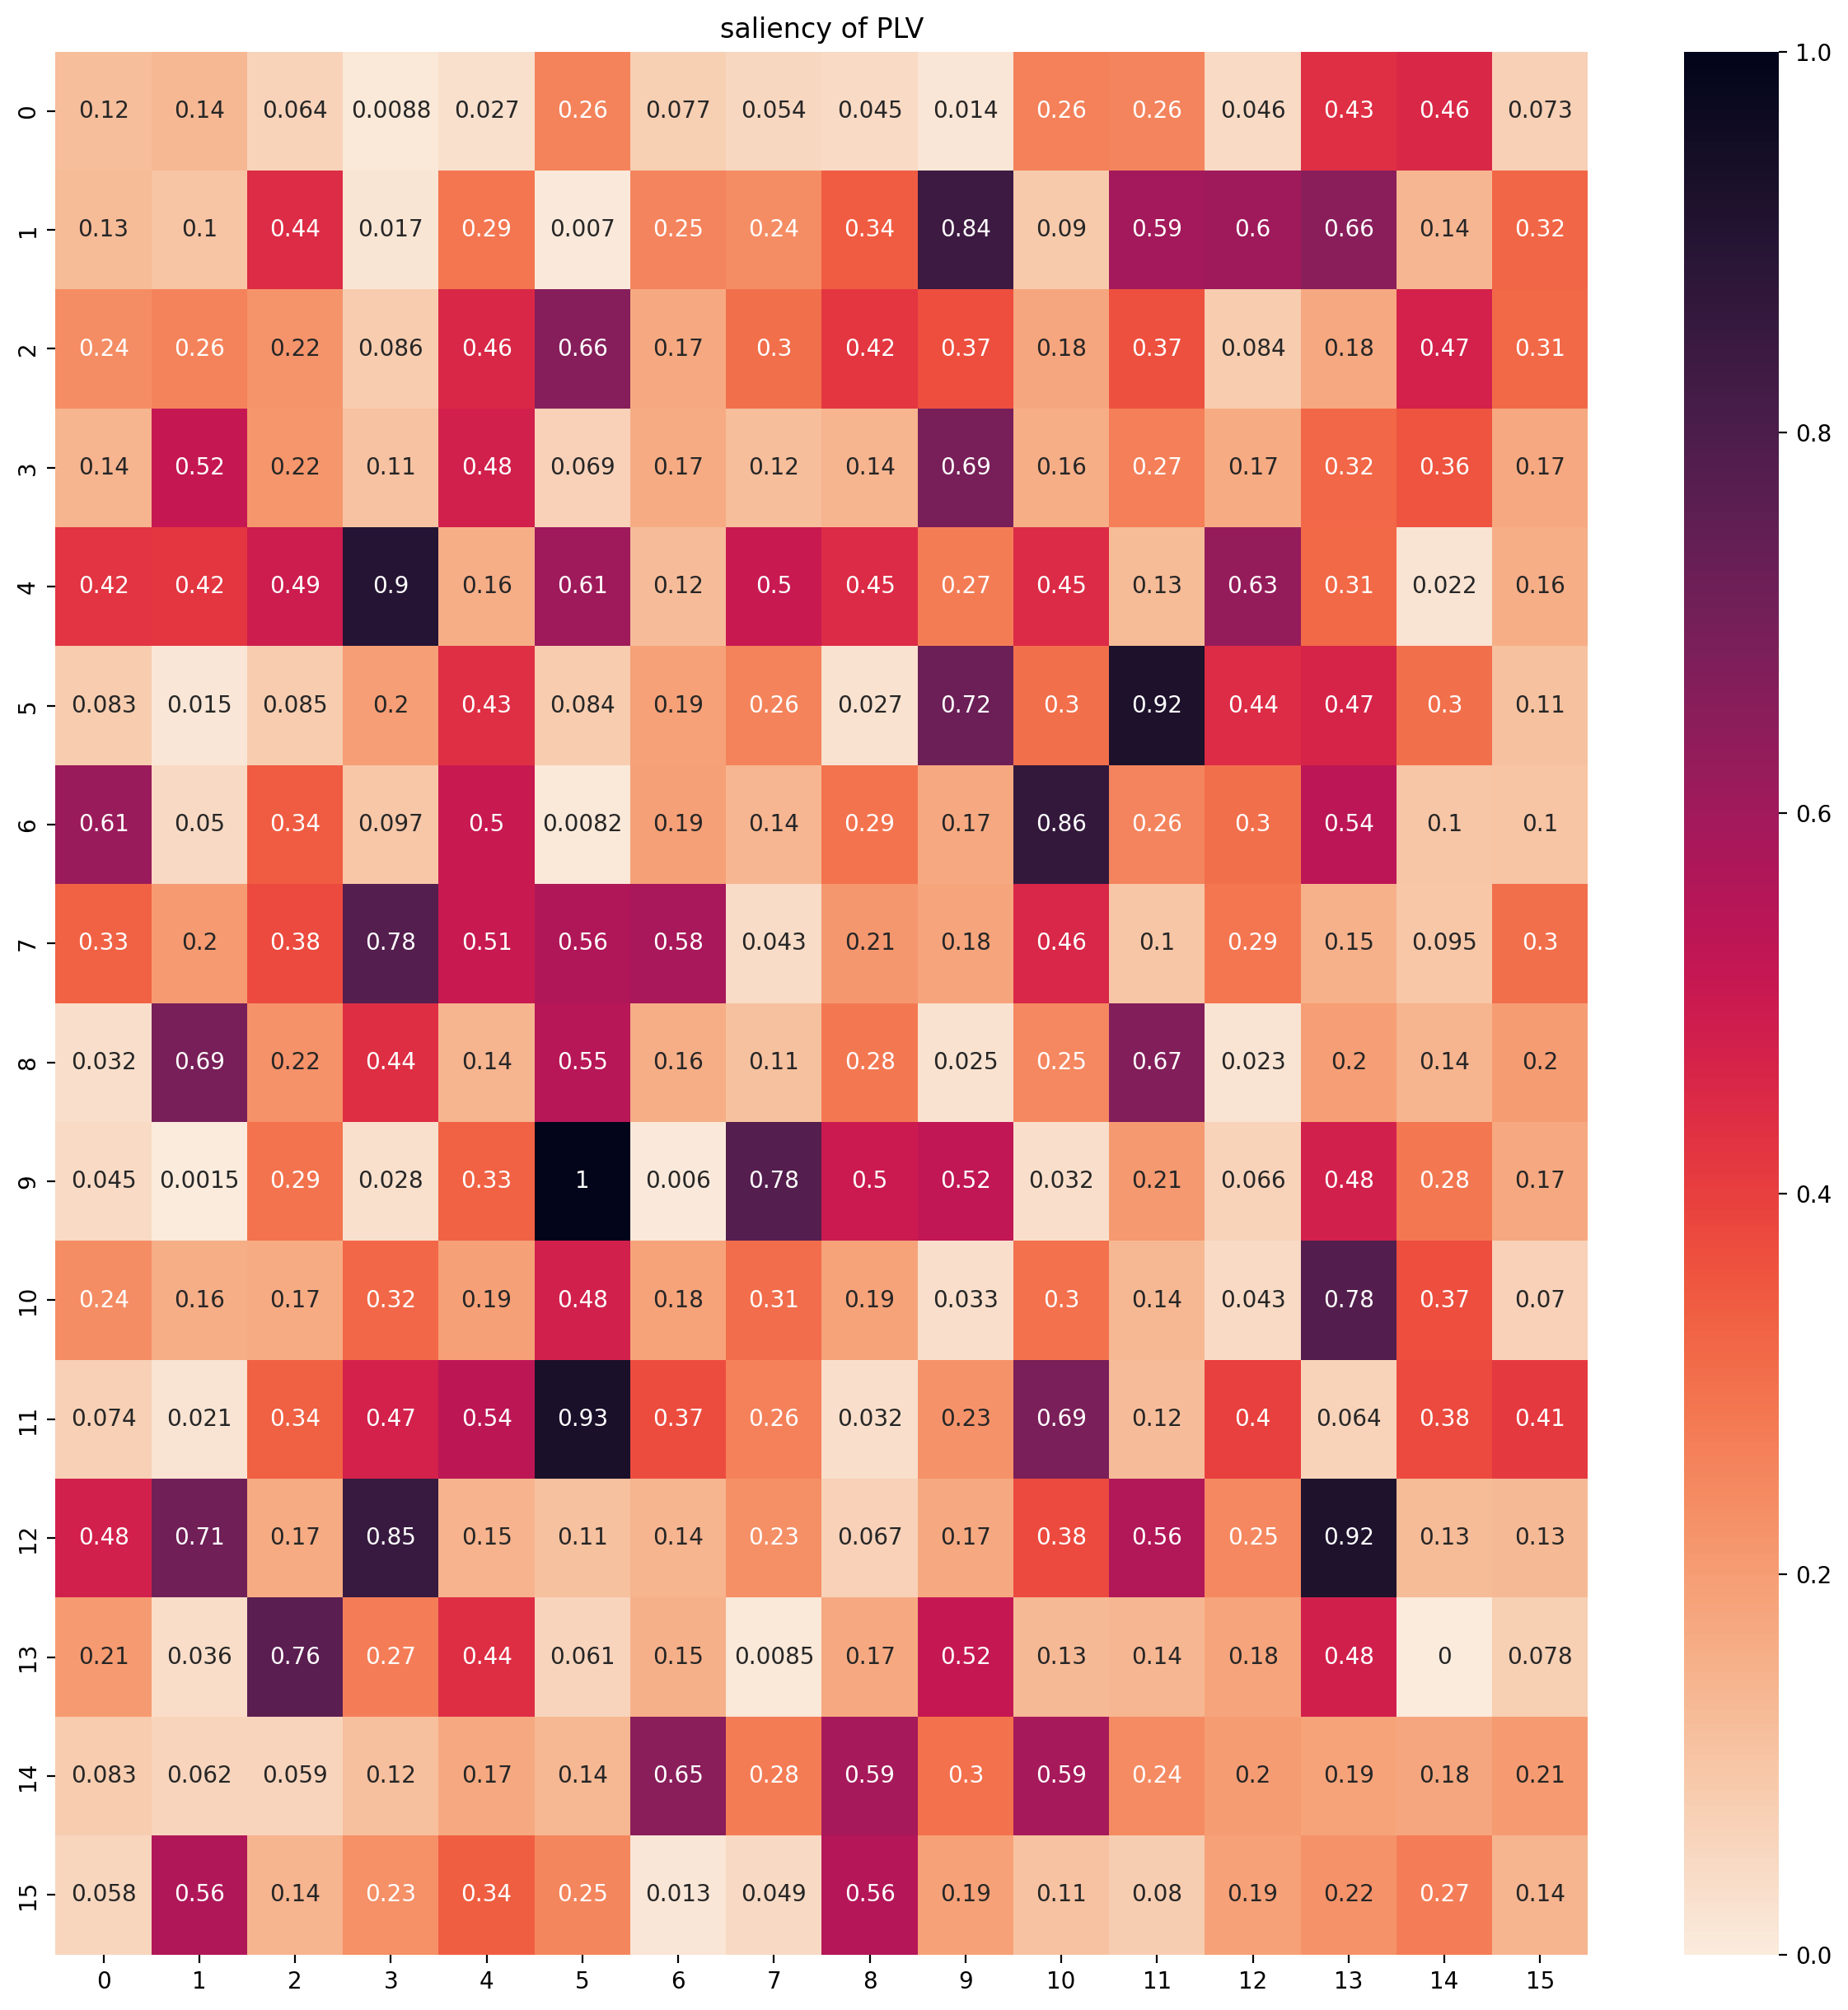

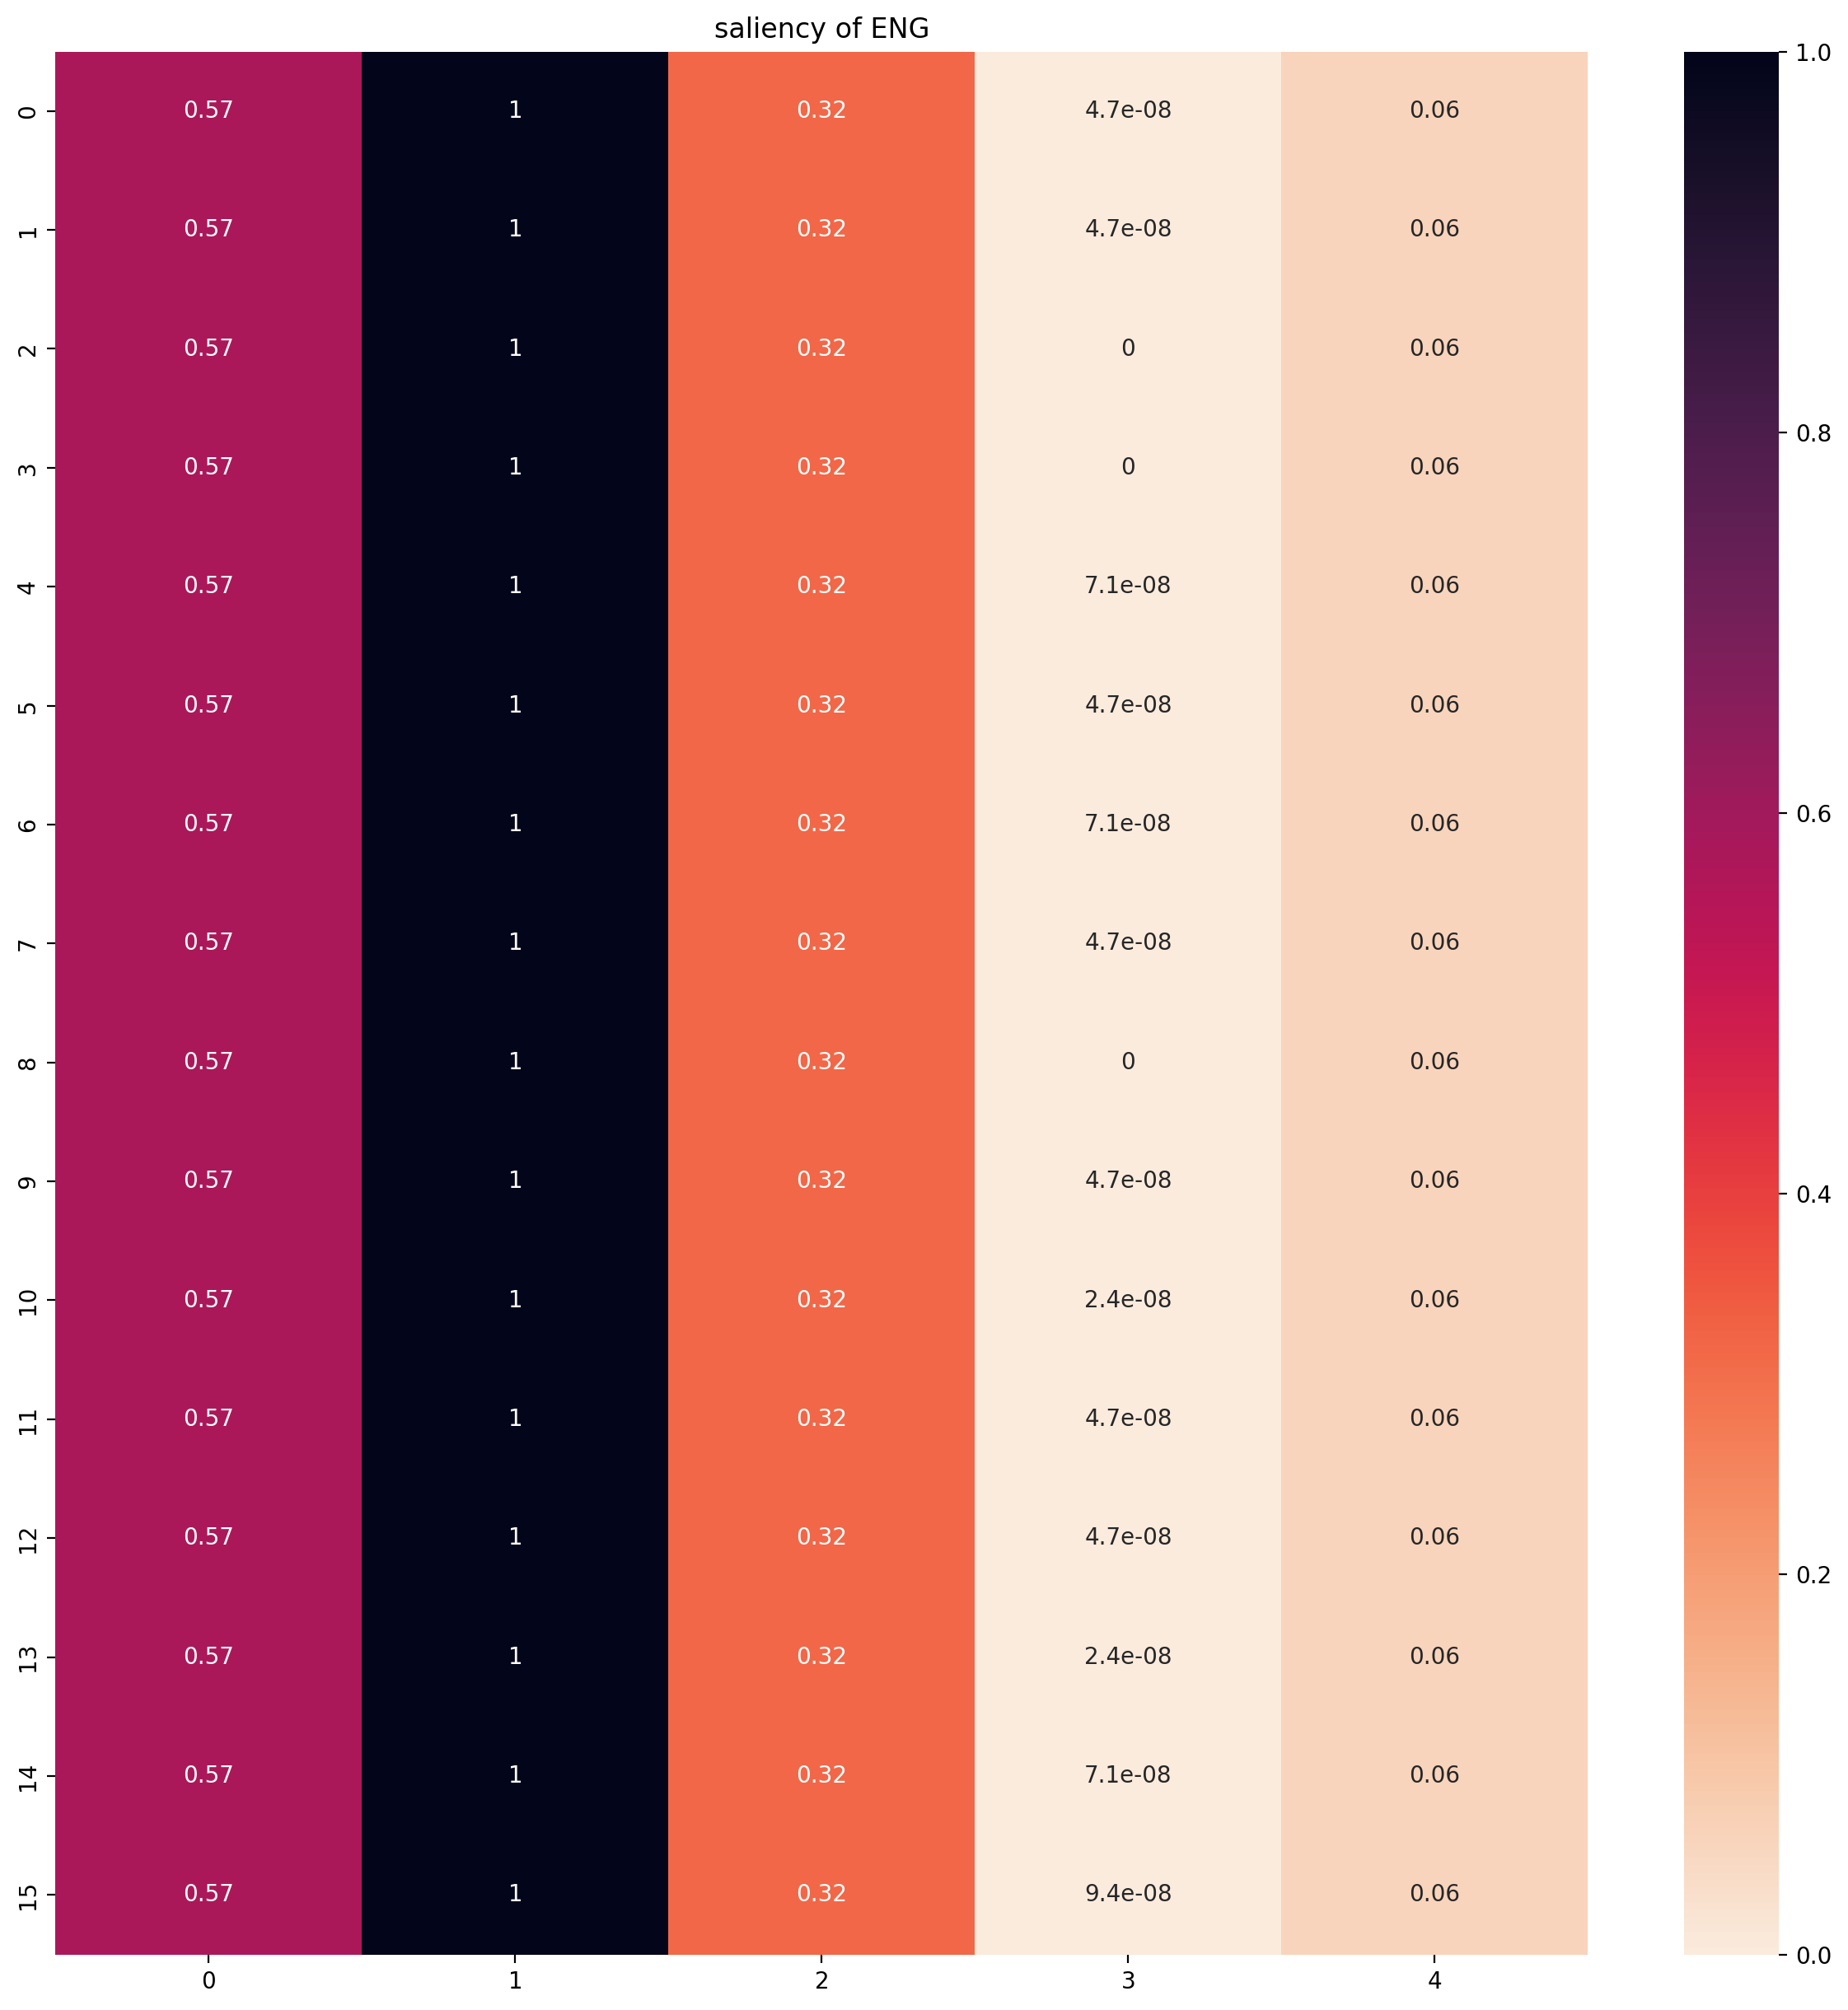

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 归一化一下，好看一些
def normalize_matrix(matrix):
    matrix = np.array(matrix)
    min_val = np.min(matrix)
    max_val = np.max(matrix)
    normalized_matrix = (matrix - min_val) / (max_val - min_val)
    return normalized_matrix

saliency_x2 = normalize_matrix(saliency_x2)

plt.figure(dpi=200,figsize=(15,15))
sns.heatmap(saliency_x2, annot=True, cmap='rocket_r')
plt.title('saliency of PLV')
plt.show()

saliency_x1 = normalize_matrix(saliency_x1)

plt.figure(dpi=200,figsize=(15,15))
sns.heatmap(saliency_x1, annot=True, cmap='rocket_r')
plt.title('saliency of ENG')
plt.show()

## 使用mne绘制能量图与连接图

In [5]:
from utils.plot_relation_map import plot_relation_map
node_names = ['F7', 'Oz', 'O1', 'F2', 'C3', 'T7', 'P4', 'T8']
plot_relation_map(saliency_x2,node_names)

TypeError: 'int' object is not iterable